<a href="https://colab.research.google.com/github/jmhuer/Fall2021MusicResearch/blob/main/HarmonyReductionAndDecompostion/pytorch_AEwLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pretty_midi
!git clone https://github.com/jmhuer/ModularSparseAutoencoder
# !git clone https://github.com/music-x-lab/POP909-Dataset
!git clone https://github.com/jmhuer/HT
!git clone https://github.com/Tsung-Ping/functional-harmony
# %cd /content/POP909-Dataset/data_process
!pip install libfmp

     |████████████████████████████████| 5.6 MB 14.4 MB/s 
     |████████████████████████████████| 51 kB 8.8 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591953 sha256=9892411309af096b1b961b31476943ec06ae1ea02d1d0b19e83711887e71833f
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi
Cloning into 'ModularSparseAutoencoder'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 28 (delta 12), reused 10 (delta 2), pack-reused 0
Unpacking objects: 100% (28/28), done.
Cloning into 'HT'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 32 (delta 14), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (32/32), done.
Cloning into 'functional-harmony'...
remote: Enum

In [2]:
#@title Pytorch for DL

import torch.nn.functional as F
import torch.optim as optim
from torch import nn
import torch
from torch.nn.utils import weight_norm
import numpy as np
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device: ", device)


def get_model_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

Using device:  cuda


In [3]:
# !pip install tensorflow-gpu==1.15
from HT.chord_symbol_recognition import train_HT
from collections import Counter, namedtuple


# Chord symbol recognition
# train_BTC() # Bi-directional Transformer for Chord Recognition
# train_CRNN() # Convolutional Recurrent Neural Network
root_dict = {'C': 0, 'C+': 1, 'D': 2, 'D+': 3, 'E': 4, 'F': 5, 'F+': 6, 'G': 7, 'G+': 8, 'A': 9, 'A+': 10, 'B': 11, 'pad': 12}
tquality_dict = {'M': 0, 'm': 1, 'O': 2, 'pad': 3}  # 'O' stands for 'others'
n_chord_classes = 24 + 1  # 24 major-minor modes plus 1 others


# Hyperparameters
hyperparameters = namedtuple('hyperparameters',
                              ['dataset',
                              'test_set_id',
                              'graph_location',
                              'n_root_classes',
                              'n_tquality_classes',
                              'n_chord_classes',
                              'n_steps',
                              'input_embed_size',
                              'n_layers',
                              'n_heads',
                              'train_sequence_with_overlap',
                              'initial_learning_rate',
                              'drop',
                              'n_batches',
                              'n_training_steps',
                              'n_in_succession',
                              'annealing_rate'])

hp = hyperparameters(dataset='/content/', # {'BPS_FH', 'Preludes'}
                      test_set_id=1, # {1, 2, 3, 4}
                      graph_location='model',
                      n_root_classes=len(root_dict.keys()),
                      n_tquality_classes=len(tquality_dict.keys()),
                      n_chord_classes=n_chord_classes,
                      n_steps=128,
                      input_embed_size=128,
                      n_layers=2,
                      n_heads=4,
                      train_sequence_with_overlap=True,
                      initial_learning_rate=1e-4,
                      drop=0.1,
                      n_batches=40,
                      n_training_steps=100000,
                      n_in_succession=10,
                      annealing_rate=1.1)

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
from HT.BPS_FH_preprocessing import main

main()

Message: load note data ...
lowest pitch = 24 highest pitch =  101
Message: load chord labels...
Message: get framewise labels ...
max_length = 8482
min_length = 872
keys in corpus['op'] = dict_keys(['pianoroll', 'chromagram', 'start_time', 'label'])
label fields =  [('op', '<U10'), ('onset', '<f8'), ('key', '<U10'), ('degree1', '<U10'), ('degree2', '<U10'), ('quality', '<U10'), ('inversion', '<i8'), ('rchord', '<U10'), ('root', '<U10'), ('tquality', '<U10'), ('chord_change', '<i8')]
Running Message: augment data...
keys in corpus_aug['shift_id']['op'] = dict_keys(['pianoroll', 'tonal_centroid', 'start_time', 'label'])
Running Message: reshape data...
keys in corpus_aug_reshape['shift_id']['op'] = dict_keys(['pianoroll', 'tonal_centroid', 'start_time', 'label', 'len'])
sequence_len_non_overlaped = [17, 22, 23, 24, 30, 34, 36, 40, 44, 48, 52, 53, 66, 72, 80, 84, 86, 88, 100, 102, 104, 116, 118, 120, 128]
sequence_len_overlaped = [17, 22, 23, 24, 30, 34, 36, 40, 44, 48, 52, 53, 66, 72, 8

In [5]:
# !pip install tensorflow-gpu==1.15
from HT.chord_symbol_recognition import train_HT
from collections import Counter, namedtuple
from HT.BPS_FH_preprocessing import main
from HT.chord_symbol_recognition import load_data_symbol
#

import pickle
import os
import sys
# import utils
import pretty_midi 
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch


class BPS(Dataset):
    def __init__(self, data):
        "todo: transpose"
        self.all_data = []
        temp = []
        self.label = []
        temp2 = []
        self.chord_change = []
        temp3 = []      
        i = 0 
        for pi,chord, cc in zip(data["pianoroll"],data["tchord"],data['label']['chord_change']):
            temp.append(torch.tensor(pi[None,:,12:76]).double())
            temp2.append(torch.tensor(chord).double())
            temp3.append(torch.tensor(cc).double())
            i+=1
            if i > 30000: break
        self.all_data = torch.stack(temp).permute(0,1,3,2)
        self.label = torch.stack(temp2)
        self.chord_change = torch.stack(temp3)
        print("data" , self.all_data.shape)
        print("label" , self.label.shape)
        ##time.sleep(120)
        self.transform = self.make_transform()
    def __len__(self):
        return len(self.all_data)
    def __getitem__(self, idx):
        piano_roll_slice = self.all_data[idx,:,:]
        label_slice = self.label[idx]
        chord_change_slice = self.chord_change[idx]
        # tranformed_piano_roll_slice = self.transform["norm"](piano_roll_slice[None][None])[0,0,:]
        #print(tranformed_piano_roll_slice.shape)
        #print("label_slice", label_slice)
        return piano_roll_slice, label_slice, chord_change_slice
    def make_transform(self):
        mean = self.all_data.mean()
        std = self.all_data.std() * 2
        # print("mean ", mean.shape)
        # print("std ", std.shape)
        tensor_transform = {
          'norm':
              transforms.Compose([
                  transforms.Normalize([mean], [std])  # Imagenet standards
              ]),
          "inverse_norm":
                transforms.Normalize(
                  mean= [-m/s for m, s in zip([mean], [std])],
                  std= [1/s for s in [std]]
                )
            }
        return tensor_transform


def load_data(train_data, test_data,  num_workers=0, batch_size=16, random_seed = 40):
    '''
    this data loading proccedure assumes dataset/train/ dataset/val/ folders
    also assumes transform dictionary with train and val
    '''
    dataset_train = BPS(train_data) 
    dataset_val = BPS(test_data) 

    print("Size of train dataset: ",len(dataset_train))
    print("Size of val dataset: ",len(dataset_val))

    dataloaders = {
        'train': DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True),
        'val': DataLoader(dataset_val, batch_size=batch_size, shuffle=False, drop_last=True)
    }
    return dataloaders



##only tensor transforms



train_data, test_data = load_data_symbol(dir=hp.dataset + 'BPS_FH_preprocessed_data_MIREX_Mm.pickle', test_set_id=hp.test_set_id, sequence_with_overlap=hp.train_sequence_with_overlap)
print("load_data_symbol train_data size: {}".format(train_data["tchord"].shape))



dataset = load_data(train_data, test_data, batch_size=40)

Load chord symbol data...
test_set_id = 1
keys in corpus_aug_reshape['shift_id']['op'] = dict_keys(['pianoroll', 'tonal_centroid', 'start_time', 'label', 'len'])
shift_list = ['shift_-1', 'shift_-2', 'shift_-3', 'shift_0', 'shift_1', 'shift_2', 'shift_3', 'shift_4', 'shift_5', 'shift_6']
train_op_list = ['2', '3', '4', '6', '7', '8', '10', '11', '12', '14', '15', '16', '18', '19', '20', '22', '23', '24', '26', '27', '28', '30', '31', '32']
test_op_list = ['1', '5', '9', '13', '17', '21', '25', '29']
train_data:  [('pianoroll', (54320, 128, 88)), ('tonal_centroid', (54320, 128, 6)), ('len', (54320,)), ('label', (54320, 128)), ('root', (54320, 128)), ('tquality', (54320, 128)), ('tchord', (54320, 128))]
test_data:  [('pianoroll', (294, 128, 88)), ('tonal_centroid', (294, 128, 6)), ('len', (294,)), ('label', (294, 128)), ('root', (294, 128)), ('tquality', (294, 128)), ('tchord', (294, 128))]
label fields: [('op', '<U10'), ('onset', '<f8'), ('key', '<U10'), ('degree1', '<U10'), ('degree2',

In [6]:
def piano_roll_to_pretty_midi(piano_roll, fs=8, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm


In [100]:

import IPython.display
index = 11 ## 44 66 & 0 & 1 500 omg 1021

#lets play a batch 
# tr = dataset["val"].dataset.transform["inverse_norm"]
# listen = []
for i,ba in enumerate(dataset["train"]): 
    # print(ba[0].shape)
    # break
    # print(torch.count_nonzero(ba[0][0]))
    if i == index: 
        piano_roll = ba[0][0][0]

def pad88to128(piano_roll, org=88):
    arr = np.zeros((128,int(piano_roll.shape[1])))
    pad = (128 - org)//2
    arr[pad:(128-pad),0:arr.shape[1]] = piano_roll
    return arr

print(piano_roll.shape)
arr = pad88to128(piano_roll, org=64)
pm = piano_roll_to_pretty_midi(arr)
IPython.display.Audio(pm.synthesize(fs=16000), rate=16000)

torch.Size([64, 128])


In [9]:
import argparse
import datetime
import json
import os

import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim




def get_args():
    parser = argparse.ArgumentParser()

    # Architecture Flags
    parser.add_argument('--intermediate_dim', type=int, default=48)
    parser.add_argument('--stripe_dim', type=int, default=24)
    parser.add_argument('--num_stripes', type=int, default=48)
    parser.add_argument('--num_active_neurons', type=int, default=24)
    parser.add_argument('--num_active_stripes', type=int, default=5)
    parser.add_argument('--layer_sparsity_mode', type=str, default='lifetime')  # Set to none, ordinary, boosted, or lifetime.
    parser.add_argument('--stripe_sparsity_mode', type=str, default='routing')  # Set to none, ordinary, or routing.
    parser.add_argument('--distort_prob', type=float, default=.01)  # Probability of stripe sparsity mask bits randomly flipping.
    parser.add_argument('--distort_prob_decay', type=float, default=.025)  # Lowers distort_prob by this amount every epoch.

    # Boosting Flags - Only necessary when layer_sparsity_mode is set to boosted.
    parser.add_argument('--alpha', type=float, default=.8)
    parser.add_argument('--beta', type=float, default=1.2)


    # Routing Flags - Only necessary when stripe_sparsity_mode is set to routing.
    parser.add_argument('--routing_l1_regularization', type=float, default=0.1)
    parser.add_argument('--log_average_routing_scores', type=bool, default=True)

    # Lifetime Stripe Flag - Only necessary when stripe_sparsity_mode is set to lifetime.
    # Within a stripe, this specifies the proportion of samples that may activate the stripe.
    parser.add_argument('--active_stripes_per_batch', type=float, default=7)

    # Training Flags
    parser.add_argument('--lr', type=float, default=.0001)
    parser.add_argument('--momentum', type=float, default=.1)
    parser.add_argument('--num_epochs', type=int, default=8)
    parser.add_argument('--batch_size', type=int, default=8)
    parser.add_argument('--data_path', type=str, default='data.csv')
    parser.add_argument('--log_path', type=str, default='logs')
    parser.add_argument('--log_class_specific_losses', type=bool, default=False)
    parser.add_argument('--log_average_activations', type=bool, default=True)
    parser.add_argument('--use_cuda_if_available', type=bool, default=True)

    args, unknown = parser.parse_known_args()
    return vars(args)
args = get_args()
print(args["intermediate_dim"])

48


In [65]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
from ModularSparseAutoencoder.model import Net
from ModularSparseAutoencoder.train import train


num_stripes = args['num_stripes']
num_epochs = args['num_epochs']
batch_size = args['batch_size']

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#assuming x shape [batch,channel=1,pitch,time]
net = Net(args['intermediate_dim'],
          args['stripe_dim'],
          args['num_stripes'],
          args['num_active_neurons'],
          args['num_active_stripes'],
          args['layer_sparsity_mode'],
          args['stripe_sparsity_mode'],
          args['distort_prob'],
          args['alpha'],
          args['beta'],
          args['active_stripes_per_batch'],
          device).double().to(device)

# net.load_state_dict(torch.load("/content/net.pth"))

AEcriterion = nn.MSELoss().to(device)
# optimizer = optim.SGD(net.parameters(),
#                       lr=args['lr'],
#                       momentum=args['momentum'])
optimizer = optim.Adam(net.parameters(), lr=args['lr'],  
                       betas=(0.8, 0.999), eps=1e-08, weight_decay=0, amsgrad=True) ##this has weight decay just like you implemented

timestamp = str(datetime.datetime.now()).replace(' ', '_')
root_path = os.path.join(args['log_path'],
                          args['layer_sparsity_mode'],
                          args['stripe_sparsity_mode'],
                          timestamp)
print(f'Logging results to path:  {root_path}')

distort_prob_decay = args['distort_prob_decay']
routing_l1_regularization = (args['routing_l1_regularization'] if args['stripe_sparsity_mode'] == 'routing' else 0)
log_class_specific_losses = args['log_class_specific_losses']
should_log_average_routing_scores = (
            args['stripe_sparsity_mode'] == 'routing' and args['log_average_routing_scores'])

train(net,
      criterion,
      optimizer,
      root_path,
      dataset,
      num_stripes,
      num_epochs,
      distort_prob_decay,
      routing_l1_regularization,
      log_class_specific_losses,
      should_log_average_routing_scores)

# if args['log_average_activations']:
#     average_activations_path = os.path.join(root_path, 'average_activations.json')
#     with open(average_activations_path, 'w') as f:
#         average_activations = net.get_average_activations(X_test, Y_test, device=device).tolist()
#         f.write(json.dumps(average_activations))

flag_values_path = os.path.join(root_path, 'experiment_config.json')
with open(flag_values_path, 'w') as f:
    f.write(json.dumps(args))

Logging results to path:  logs/lifetime/routing/2021-10-20_04:35:52.130685
Epoch : 0 	 Loss : 10.078323127 
Epoch : 1 	 Loss : 1.309999496 
Epoch : 2 	 Loss : 0.038374623 
Epoch : 3 	 Loss : 0.036115773 
Epoch : 4 	 Loss : 0.03528038 
Epoch : 5 	 Loss : 0.034630574 
Epoch : 6 	 Loss : 0.034095252 
Epoch : 7 	 Loss : 0.033477202 


eval

In [102]:

import IPython.display
index = 11 ## 44 66 & 0 & 1 500 omg 1021

for i,batch in enumerate(dataset["train"]): 
    if i == index: 
        x_var = batch[0].permute(0,1,3,2).to(net.device).float()
        xpred_var = net(x_var).permute(0,1,3,2)
        print(xpred_var.shape)
        piano_roll = xpred_var[0][0].detach().cpu()
        piano_roll = (piano_roll>=0.5) 

def pad88to128(piano_roll, org=88):
    arr = np.zeros((128,int(piano_roll.shape[1])))
    pad = (128 - org)//2
    arr[pad:(128-pad),0:arr.shape[1]] = piano_roll
    return arr

print(piano_roll.shape)
arr = pad88to128(piano_roll, org=64)
pm = piano_roll_to_pretty_midi(arr)
IPython.display.Audio(pm.synthesize(fs=16000), rate=16000)

torch.Size([40, 1, 64, 128])
torch.Size([64, 128])


(<Figure size 576x216 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa51ea17110>)

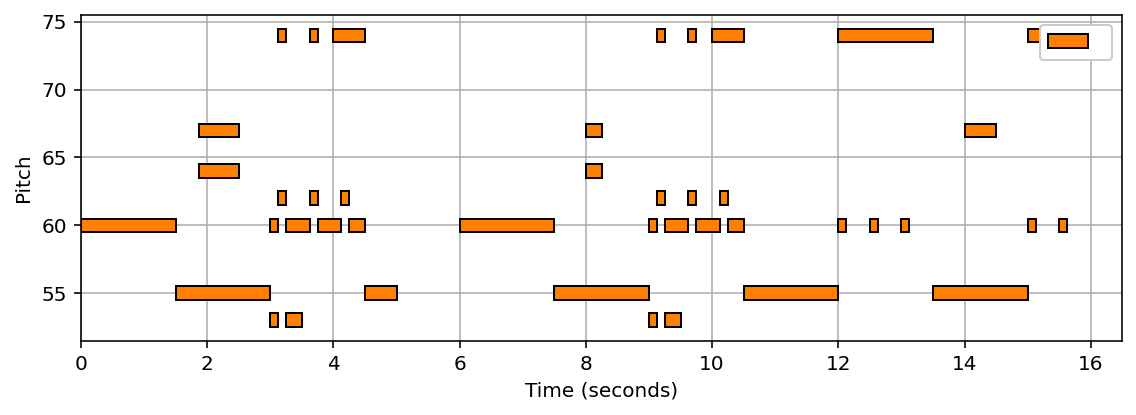

In [103]:
import libfmp.c1
score = libfmp.c1.midi_to_list(pm)

libfmp.c1.visualize_piano_roll(score, figsize=(8, 3))

#bidirectional LSTM

In [ ]:

class LSTM(nn.Module):

    def __init__(self, img_channel, img_height, img_width, num_class,
                 map_to_seq_hidden=64, rnn_hidden=256, leaky_relu=False):
        super(LSTM, self).__init__()

        self.map_to_seq = nn.Linear(img_channel * img_height, map_to_seq_hidden) ##manually changed this to turn off conv 

        self.rnn1 = nn.LSTM(map_to_seq_hidden, rnn_hidden, bidirectional=True)
        self.rnn2 = nn.LSTM(2 * rnn_hidden, rnn_hidden, bidirectional=True)

        self.dense = nn.Linear(2 * rnn_hidden, num_class)

    def forward(self, images):
        # shape of images: (batch, channel, height, width)
        # conv = self.cnn(images)
        conv = images 
        batch, channel, height, width = conv.size()
        conv = conv.view(batch, channel * height, width)
        conv = conv.permute(2, 0, 1)  # (width, batch, feature)
        seq = self.map_to_seq(conv)
        recurrent, _ = self.rnn1(seq)
        recurrent, _ = self.rnn2(recurrent)

        output = self.dense(recurrent)
        return output  # shape: (seq_len, batch, num_class)


In [104]:

def accuracy(outputs, labels):
    outputs_idx = torch.argmax(outputs, dim=1)
    return outputs_idx.eq(labels).float().mean()


def test_batch(lstm, data, optimizer, criterion, device):
    lstm.train()
    images, targets, target_lengths = [d.to(device) for d in data]
    logits = lstm(images.float())
    logits = logits.permute(1,2,0)
    target_lengths = logits.size(2)
    targets = targets[:,-1*target_lengths:].long()
    assert targets.size(1)==logits.size(2)
    loss = criterion(logits,targets)
    acc = round(accuracy(logits, targets).item(),3)
    loss = round(loss.item(),3)
    return loss, acc

def train_LSTMbatch(lstm, data, optimizer, criterion, device):
    lstm.train()
    images, targets, target_lengths = [d.to(device) for d in data]
    logits = lstm(images.float())
    logits = logits.permute(1,2,0)
    target_lengths = logits.size(2)
    targets = targets[:,-1*target_lengths:].long()
    # print("target", targets.shape)
    assert targets.size(1)==logits.size(2)
    # loss = criterion(log_probs, targets, input_lengths, target_lengths)
    loss = criterion(logits,targets)
  
    return loss, logits

def train_AEbatch(train_data, routing_l1_regularization=False):
    x_var = train_data[0].permute(0,1,3,2).to(net.device).float()
    xpred_var = net(x_var).permute(0,1,3,2)
    print(xpred_var.shape)
    piano_roll = xpred_var[0][0].detach().cpu()
    train_data[0] = (piano_roll>=0.5) 
    AEloss = criterion(xpred_var, x_var)
    if routing_l1_regularization:
        AEloss += routing_l1_regularization * torch.norm(net.routing_layer.weight, p=1)
    return AEloss, train_data




class History:
    def __init__(self, batch_size):

      self.TRAIN_epoch = []
      self.TRAIN_totalloss = []
      self.TRAIN_AEloss = []
      self.TRAIN_LSTMloss = []
      self.TRAIN_train_acc = []
            
      self.TEST_epoch = []
      self.TEST_totalloss =[]
      self.TEST_AEloss = []
      self.TEST_LSTMloss = []
      self.TEST_test_acc = []

      self.batch_size = batch_size
        
    def addtrain(self,epoch,totalloss, LSTMloss,AEloss,acc):
        self.TRAIN_epoch.append(epoch)
        self.TRAIN_totalloss.append(totalloss)
        self.TRAIN_AEloss.append(AEloss)
        self.TRAIN_LSTMloss.append(LSTMloss)
        self.TRAIN_train_acc.append(acc)
    def addtest(self,epoch,totalloss,LSTMloss,AEloss,acc):
        self.TEST_epoch.append(epoch)
        self.TEST_totalloss.append(totalloss)
        self.TEST_AEloss.append(AEloss)
        self.TEST_LSTMloss.append(LSTMloss)
        self.TEST_train_acc.append(acc)
    def print_train_status(self):
        print('train_loss: ', self.TRAIN_totalloss / self.tot_train_count,'\t train acc: ', self.tot_train_acc/ (self.tot_train_count//self.train_size))
    def print_test_status(self):
        print('test_loss: ', self.tot_test_loss / self.tot_test_count,'\t test acc: ', self.tot_test_acc/ (self.tot_test_count//self.test_size))


In [ ]:
# from model import CRNN
# from train import train_batch, test_batch
import torch
from torch.utils.data import DataLoader
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)


lstm = LSTM(1, img_height=64, img_width=128, num_class=26,
            map_to_seq_hidden=128,
            rnn_hidden=128*2,
            leaky_relu=True)

# if reload_checkpoint:
#     lstm.load_state_dict(torch.load(reload_checkpoint, map_location=device))

lstm = lstm.to(device)

# optimizer = optim.RMSprop(lstm.parameters(), lr=0.05)
optimizer = optim.Adam(lstm.parameters(), lr=0.01,  
                       betas=(0.8, 0.999), eps=1e-08, weight_decay=0, amsgrad=True) ##this has weight decay just like you impl

LSTMcriterion = torch.nn.CrossEntropyLoss().to(device)
criterion.to(device)

epochs = 10
i = 1

test_size = dataset["train"].dataset.all_data[0].size(0) #testbatchSize
train_size = dataset["val"].dataset.all_data[0].size(0) #trainbatchSize


status = history()
AE=True
for epoch in range(1, epochs + 1):
    ##~~~~~~~~~~TRAIN~~~~~~~~~~
    for _batchdata in dataset["train"]:
            #AE STUFF BELOW
            if AE==True:
                AEloss, E_batchdata  = train_AEbatch(_batchdata)
            elif AE==False:
                E_batchdata = train_data
                AEloss = 0
            
            #LSTM STUFF BELOW
            lstmloss, logits = train_LSTMbatch(lstm, E_batchdata, optimizer, criterion, device)
            acc = round(accuracy(logits, targets).item(),3)

            #COMBINED LOSS 
            loss = AEloss + lstmloss

            #OPTIMIZEe
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #store history
            totalloss, LSTMloss ,AEloss  = round(loss.item(),3), round(lstmloss.item(),3), round(AEloss.item(),3)
            status.addtest(totalloss,LSTMloss,AEloss,acc)
            status.printtest()


    ##~~~~~~~~~~TEST~~~~~~~~~~
    for _data in dataset["val"]:
            #AE STUFF BELOW
            if AE==True:
                AEloss, E_batchdata  = test_AEbatch(_data)
            elif AE==False:
                E_batchdata = test_data
                AEloss = 0
            
            #LSTM STUFF BELOW
            lstmloss, logits = test_LSTMbatch(lstm, E_batchdata, device)
            acc = round(accuracy(logits, targets).item(),3)

            #COMBINED LOSS 
            loss = AEloss + lstmloss

            #store history
            totalloss, LSTMloss ,AEloss  = round(loss.item(),3), round(lstmloss.item(),3), round(AEloss.item(),3)
            status.addtest(totalloss,LSTMloss,AEloss,acc)
            status.printtest()


#

cuda
epoch: 1
train_loss:  0.014863066666666648 	 train acc:  0.818044
test loss:  0.018514285714285716 	 acc:  0.8001428571428572
epoch: 2
train_loss:  0.00770106666666666 	 train acc:  0.9020426666666673
test loss:  0.020653571428571434 	 acc:  0.7912857142857144
epoch: 3
train_loss:  0.00973026666666666 	 train acc:  0.8758520000000005
test loss:  0.02022857142857143 	 acc:  0.7882857142857144
epoch: 4
train_loss:  0.01015646666666667 	 train acc:  0.870062666666666
test loss:  0.020871428571428572 	 acc:  0.7774285714285715
epoch: 5
train_loss:  0.013927799999999997 	 train acc:  0.8241266666666669
test loss:  0.021564285714285716 	 acc:  0.7555714285714286
epoch: 6
train_loss:  0.02082469999999999 	 train acc:  0.7411599999999997
test loss:  0.02731785714285714 	 acc:  0.6651428571428571
epoch: 7
train_loss:  0.02451149999999997 	 train acc:  0.6948026666666671
test loss:  0.02649642857142857 	 acc:  0.683
epoch: 8
train_loss:  0.02158839999999997 	 train acc:  0.7290346666666666


In [ ]:
# !git clone https://github.com/GitYCC/crnn-pytorch
# %cd crnn-pytorch/

[autoreload of train failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/content/crnn-pytorch/src/train.py", line 23
    break
    ^
SyntaxError: 'break' outside

Cloning into 'crnn-pytorch'...
^C
[Errno 2] No such file or directory: 'crnn-pytorch/'
/content/crnn-pytorch/src
